<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a>
</p>
<p align="center">
<a href="https://discord.gg/AMApC2UzVY"><img alt="Discord" src="https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord"></a>
<a href="https://twitter.com/vlmrun"><img alt="Twitter Follow" src="https://img.shields.io/twitter/follow/vlmrun.svg?style=social&logo=twitter"></a>
</p>
</div>

# Getting Started with VLM Run API

This notebook demonstrates how to use [VLM Run](https://vlm.run) to extract structured data from visual content.

We'll cover three ways to interact with the API:
1. Using the official `vlmrun` client (recommended)
2. Using the OpenAI SDK (familiar for OpenAI users) 
3. Using the requests library directly

## Prerequisites

* Python 3.9+
* VLM Run API key (get one at [vlm.run](https://vlm.run))

## Setup

First, let's install the required packages:

In [1]:
! pip install vlmrun --upgrade --quiet
! pip install vlmrun-hub --upgrade --quiet
! pip install openai --quiet

## Example: Invoice Analysis

Let's analyze an example invoice using VLM Run. We'll download a sample invoice and extract structured data from it.

In [2]:
from vlmrun.common.utils import download_image
from PIL import Image
from IPython.display import display

image: Image.Image = download_image("https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.invoice/invoice_1.jpg")

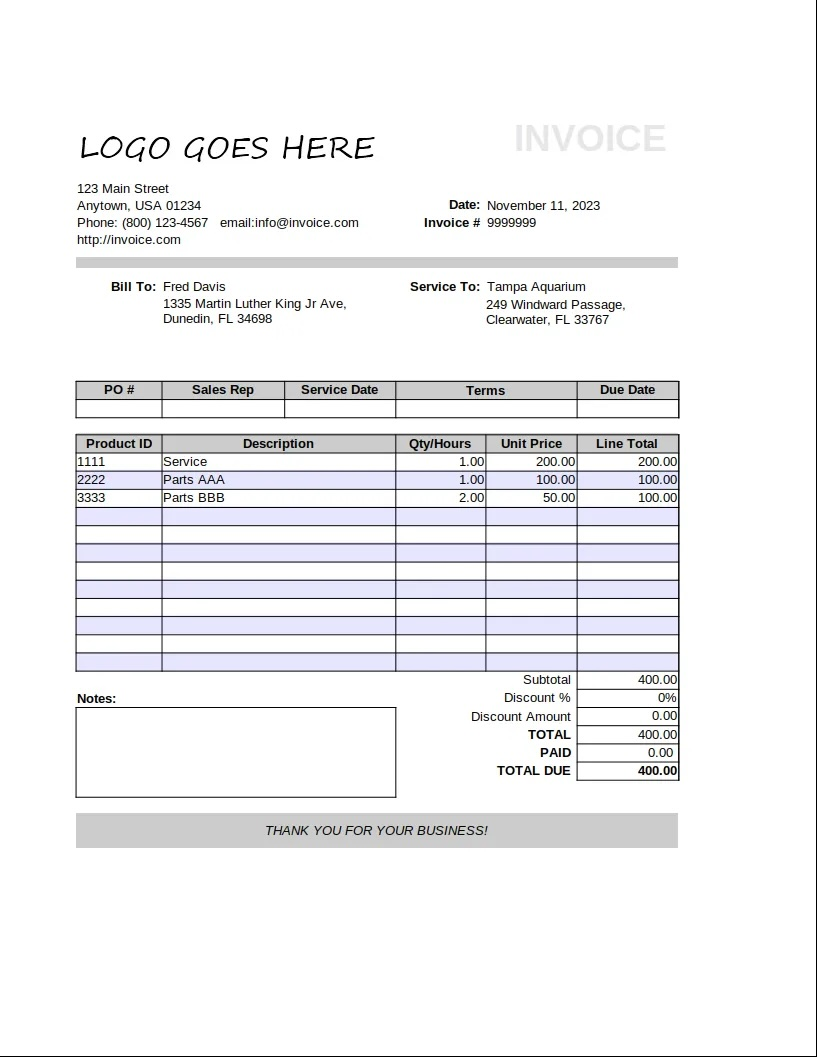

In [3]:
display(image)

### Method 1: Using the VLM Run Client (Recommended)

The `VLMRun` client provides the most straightforward way to interact with the API:

In [4]:
import os
import getpass

VLMRUN_BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://dev.vlm.run/v1")
VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass()

 ········


In [5]:
# Initialize the client
from vlmrun.client import VLMRun

client = VLMRun(base_url=VLMRUN_BASE_URL, api_key=VLMRUN_API_KEY)

In [6]:
from vlmrun.client.types import PredictionResponse

IMAGE_URL = "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.invoice/invoice_1.jpg"

response: PredictionResponse = client.image.generate(
    images=[image],
    domain="document.invoice",
)

In [7]:
# Utility function to print VLM response for invoice data

def print_invoice_response(response_data):
    if hasattr(response_data, 'model_dump'):
        data = response_data.model_dump()
    else:
        data = response_data

    response = data.get('response', data)
    
    print(f"""
Response Details:
----------------
ID: {data.get('id', 'N/A')}
Created: {data.get('created_at', 'N/A')}
Status: {data.get('status', 'N/A')}
Credits Used: {data.get('usage', {}).get('credits_used', 'N/A')}

Extracted Data:
--------------
Invoice ID: {response.get('invoice_id', 'N/A')}
Customer: {response.get('customer', 'N/A')}
Issue Date: {response.get('invoice_issue_date', 'N/A')}
Total Amount: ${response.get('total', 'N/A')}

Customer Details:
---------------
Email: {response.get('customer_email', 'N/A')}
Phone: {response.get('customer_phone', 'N/A')}

Billing Address:
--------------""")
    
    billing = response.get('customer_billing_address', {})
    if billing:
        print(f"{billing.get('street', '')}")
        print(f"{billing.get('city', '')}, {billing.get('state', '')} {billing.get('postal_code', '')}")
        print(f"{billing.get('country', '')}")
    else:
        print("No billing address provided")
    
    print("\nItems:")
    print("------")
    for item in response.get('items', []):
        print(f"- {item.get('quantity', 'N/A')}x {item.get('description', 'N/A')}: "
              f"${item.get('total_price', 'N/A')}")
    
    print(f"\nSubtotal: ${response.get('subtotal', 'N/A')}")
    print(f"Tax: ${response.get('tax', 'N/A')}")
    print(f"Total: ${response.get('total', 'N/A')}")

In [8]:
print_invoice_response(response)


Response Details:
----------------
ID: 88e1672f-14ac-4ee1-be22-fc0655d42d0e
Created: 2025-02-05 10:03:11.485553
Status: completed
Credits Used: 1

Extracted Data:
--------------
Invoice ID: 9999999
Customer: Fred Davis
Issue Date: 2023-11-11
Total Amount: $400.0

Customer Details:
---------------
Email: info@invoice.com
Phone: (800) 123-4567

Billing Address:
--------------
1335 Martin Luther King Jr Ave
Dunedin, FL 34698
None

Items:
------
- 1x Service: $200.0
- 1x Parts AAA: $100.0
- 2x Parts BBB: $100.0

Subtotal: $400.0
Tax: $None
Total: $400.0


## Method 2: Using the OpenAI SDK 

VLM Run provides [OpenAI API compatibility](https://docs.vlm.run/integrations/integrations-openai-compatibility), allowing you to use the familiar OpenAI SDK:

In [9]:
from openai import OpenAI
import json

In [10]:
# We would have to encode the image to a suitable format
from vlmrun.common.image import encode_image

base64_str = encode_image(image, format="JPEG")

In [11]:
client = OpenAI(base_url=f"{VLMRUN_BASE_URL}/openai", api_key=VLMRUN_API_KEY)

chat_completion = client.chat.completions.create(
  model="vlm-1",
  messages=[
    {"role": "user", "content": [
        {"type": "image_url", "image_url":
        {"url": base64_str, "detail": "auto"}},
    ]}
  ],
  extra_body={
        "vlmrun": {
            "domain": "document.invoice"
        }
    }
)
response_dict = json.loads(chat_completion.choices[0].message.content)

In [12]:
print_invoice_response(response_dict)


Response Details:
----------------
ID: N/A
Created: N/A
Status: N/A
Credits Used: N/A

Extracted Data:
--------------
Invoice ID: 9999999
Customer: Fred Davis
Issue Date: 2023-11-11
Total Amount: $400.0

Customer Details:
---------------
Email: None
Phone: (800) 123-4567

Billing Address:
--------------
1335 Martin Luther King Jr Ave
Dunedin, FL 34698
None

Items:
------
- 1x Service: $200.0
- 1x Parts AAA: $100.0
- 2x Parts BBB: $100.0

Subtotal: $400.0
Tax: $0.0
Total: $400.0


## Method 3: Using Requests Directly

In [13]:
import requests

response = requests.post(
  f"{VLMRUN_BASE_URL}/image/generate",
  json={
    "model": "vlm-1",
    "domain": "document.invoice",
    "image": f"data:image/jpeg;base64,{base64_str}"
  },
  headers={
    "Authorization": f"Bearer {VLMRUN_API_KEY}",
    "Content-Type": "application/json"
  }
)
response.raise_for_status()
response_dict = response.json()

In [14]:
print_invoice_response(response_dict)


Response Details:
----------------
ID: 3a6b3efb-5444-4024-80ce-f8f9387c4db9
Created: 2025-02-05T10:04:36.840236
Status: completed
Credits Used: 1

Extracted Data:
--------------
Invoice ID: 9999999
Customer: Fred Davis
Issue Date: 2023-11-11
Total Amount: $400.0

Customer Details:
---------------
Email: info@invoice.com
Phone: (800) 123-4567

Billing Address:
--------------
1335 Martin Luther King Jr Ave
Dunedin, FL 34698
None

Items:
------
- 1x Service: $200.0
- 1x Parts AAA: $100.0
- 2x Parts BBB: $100.0

Subtotal: $400.0
Tax: $None
Total: $400.0


## Next Steps

- Explore more examples in our [cookbooks](https://docs.vlm.run/guides)
- Check out supported domains in the [Hub Catalog](https://docs.vlm.run/hub)
- Learn about [custom schemas](https://docs.vlm.run/custom-schemas) for your specific use case